## Skin Medium Resolution Color Image Modeling 

### Importing Libraries

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

%matplotlib inline

### Reading in the MetaData and Image Files

In [55]:
skin = pd.read_csv('../../datasets/HAM10000_metadata.csv')

Medium Resolution Images provide the features

In [56]:
skin_28by28 = pd.read_csv('../../datasets/hmnist_28_28_RGB.csv')#medium res images

Dropping label column(not part of original data) as only pixel data is needed

In [57]:
skin_28by28.drop('label',axis=1, inplace=True)

Joining metadata together with image data to create one DataFrame 192 pixel columns and 7 data columns

In [58]:
skin =pd.concat([skin,skin_28by28],axis = 1)

In [59]:
skin.shape

(10015, 2359)

Target Distribution

In [60]:
skin['dx'].value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

The two diagnoses I want to focus on are melanoma, 11.1% of the total and basal cell carcinoma, 5.1% of the total. To avoid unbalanced classes, take a random sample of the remaining , noncancer diagnosis purposefully not undersampling the 'nv' which is the most challenging to discern from melanoma as well as the largest portion of diagnoses 66.9%.There are 1627 cancer rows, a random sampling of 1627 noncancer rows will be selected.

In [61]:
malignant=skin[(skin['dx']=='mel')| (skin['dx']=='bcc')]
malignant.shape

(1627, 2359)

The noncancerous diagnoses are grouped together in the benign subset.

In [62]:
benign= skin[(skin['dx']=='df')|(skin['dx']=='nv')|(skin['dx']=='bkl')|(skin['dx']=='vasc')|(skin['dx']=='akiec')]
benign.shape

(8388, 2359)

Shuffling all the rows of the benign diagnosis

In [63]:
benign = benign.sample(benign.shape[0],np.random.seed(42), replace = True)
benign.shape

(8388, 2359)

For modeling the malignant diagnosis are converted to ones.

In [64]:
malignant['dx'] =1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
malignant['dx'].value_counts()

1    1627
Name: dx, dtype: int64

For modeling the noncancerous diagnoses are converted to zeroes

In [66]:
benign['dx']=0

In [67]:
benign['dx'].value_counts()

0    8388
Name: dx, dtype: int64

Malignant and a subset of benign are joined together to become skin_equal

In [68]:
skin_equal = pd.concat((malignant,benign.head(1627)))

In [69]:
skin_equal.shape

(3254, 2359)

The image_id is unique to each row, it is set as the index

In [70]:
skin_equal.set_index('image_id', inplace = True)

In [71]:
skin_equal.head()

,lesion_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,pixel0003,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,HAM_0000871,1,histo,40.0,female,chest,151,126,129,161,...,166,179,152,156,150,126,131,75,60,66
ISIC_0030623,HAM_0000871,1,histo,40.0,female,chest,201,172,187,201,...,208,209,188,207,210,186,205,209,185,205
ISIC_0027190,HAM_0000040,1,histo,80.0,male,upper extremity,137,117,136,145,...,150,141,126,147,151,136,160,143,127,149
ISIC_0031023,HAM_0005678,1,histo,60.0,male,chest,8,1,7,53,...,228,175,159,178,43,32,48,9,2,8
ISIC_0028086,HAM_0005678,1,histo,60.0,male,chest,223,204,225,235,...,250,248,240,252,242,231,241,227,210,218


In [72]:
X = skin_equal.drop(columns=['lesion_id','dx','dx_type',
                    'age', 'sex','localization'])

In [73]:
X.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,151,126,129,161,132,138,168,140,150,171,...,166,179,152,156,150,126,131,75,60,66
ISIC_0030623,201,172,187,201,172,187,203,178,194,205,...,208,209,188,207,210,186,205,209,185,205
ISIC_0027190,137,117,136,145,124,144,149,130,150,151,...,150,141,126,147,151,136,160,143,127,149
ISIC_0031023,8,1,7,53,34,51,139,106,127,162,...,228,175,159,178,43,32,48,9,2,8
ISIC_0028086,223,204,225,235,218,240,227,206,230,226,...,250,248,240,252,242,231,241,227,210,218


In [74]:
y= skin_equal[['dx']]

In [75]:
y.shape

(3254, 1)

Train Test Split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


Making sure to have correct type

In [77]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Changing to numpy array

In [78]:
X_train=X_train.values
X_test=X_test.values

Looking at X_train shape

In [79]:
X_train.shape

(2440, 2352)

In [80]:
y_train.shape

(2440, 1)

Looking at X_train first entry

In [81]:
X_train[0]

array([176., 139., 140., ..., 144.,  93.,  85.], dtype=float32)

In [82]:
# This scales each value to be between 0 and 1. 
X_train/=255
X_test/=255

In [83]:
# Reshape each image to be 28 x 28 x 3.
X_train = X_train.reshape(X_train.shape[0],28,28,3) 
X_test = X_test.reshape(X_test.shape[0],28,28,3) 
# Reshaping your images is often one of the most difficult
# aspects of machine learning with image data.

Checking shape of X_train and y_train now

In [84]:
X_train.shape

(2440, 28, 28, 3)

In [85]:
y_train.shape

(2440, 1)

### Model Construction

Starting with Feed Forward Neural Network

In [86]:
model = Sequential()

model.add(Flatten(input_shape=(28, 28, 3)))

model.add(Dense(128, input_shape=(28, 28, 3), activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(X_train,
                    y_train, 
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 344us/step - loss: 0.8536 - acc: 0.5025 - val_loss: 0.6887 - val_acc: 0.5098
Epoch 2/20
2440/2440 [==============================] - 0s 83us/step - loss: 0.6804 - acc: 0.5570 - val_loss: 0.6720 - val_acc: 0.5958
Epoch 3/20
2440/2440 [==============================] - 0s 80us/step - loss: 0.6634 - acc: 0.6225 - val_loss: 0.6596 - val_acc: 0.6425
Epoch 4/20
2440/2440 [==============================] - 0s 90us/step - loss: 0.6467 - acc: 0.6455 - val_loss: 0.6481 - val_acc: 0.6204
Epoch 5/20
2440/2440 [==============================] - 0s 81us/step - loss: 0.6357 - acc: 0.6377 - val_loss: 0.6396 - val_acc: 0.5983
Epoch 6/20
2440/2440 [==============================] - 0s 82us/step - loss: 0.6296 - acc: 0.6418 - val_loss: 0.6813 - val_acc: 0.5258
Epoch 7/20
2440/2440 [==============================] - 0s 81us/step - loss: 0.6236 - acc: 0.6443 - val_loss: 0.6527 - val_acc: 0.5393
Epoch 8

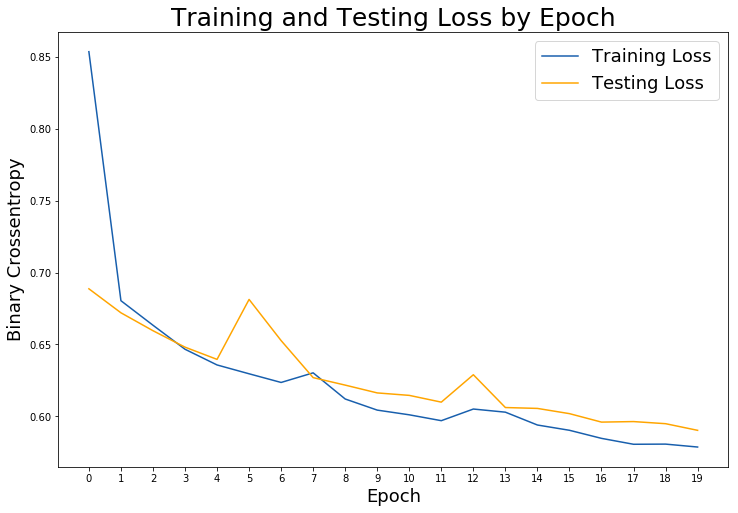

In [87]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

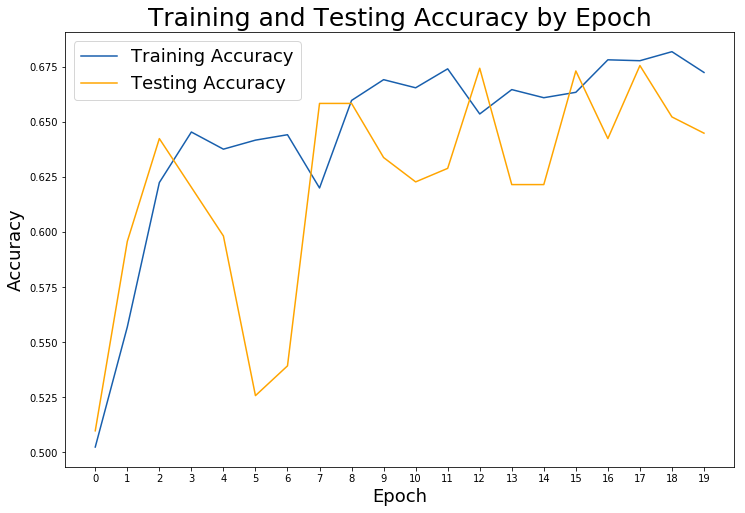

In [88]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [89]:
# Evaluate model on test data.
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

model.summary()

loss: 0.5902659238409937
acc: 0.6449631454024912
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               301184    
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 305,345
Trainable params: 305,345
Non-trainable params: 0
_________________________________________________________________


Constructing Convolutional Neural Network

In [90]:
# Instantiate a CNN.
cnn_model = Sequential()

# Add a convolutional layer.

cnn_model.add(Conv2D(filters = 6,     # number of filters
                     kernel_size = 3, # height/width of filter
                     activation = 'relu', # activation function 
                     input_shape = (28, 28, 3))) # shape of input (image)

# dimensions of region of pooling
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 

cnn_model.add(Conv2D(16,
                     kernel_size = 3,
                     activation='relu'))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 1 neuron.
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model.fit(X_train,
              y_train,
              batch_size=256,
              validation_data=(X_test, y_test),          
              epochs=20,
              verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 2s 664us/step - loss: 0.7939 - acc: 0.4959 - val_loss: 0.7099 - val_acc: 0.5000
Epoch 2/20
2440/2440 [==============================] - 1s 340us/step - loss: 0.7002 - acc: 0.5369 - val_loss: 0.6721 - val_acc: 0.6560
Epoch 3/20
2440/2440 [==============================] - 1s 355us/step - loss: 0.6521 - acc: 0.6586 - val_loss: 0.6373 - val_acc: 0.6278
Epoch 4/20
2440/2440 [==============================] - 1s 353us/step - loss: 0.6146 - acc: 0.6631 - val_loss: 0.6070 - val_acc: 0.6634
Epoch 5/20
2440/2440 [==============================] - 1s 356us/step - loss: 0.5905 - acc: 0.6713 - val_loss: 0.5912 - val_acc: 0.6671
Epoch 6/20
2440/2440 [==============================] - 1s 345us/step - loss: 0.5768 - acc: 0.6840 - val_loss: 0.5790 - val_acc: 0.6548
Epoch 7/20
2440/2440 [==============================] - 1s 358us/step - loss: 0.5810 - acc: 0.6750 - val_loss: 0.5853 - val_acc: 0.6929
E

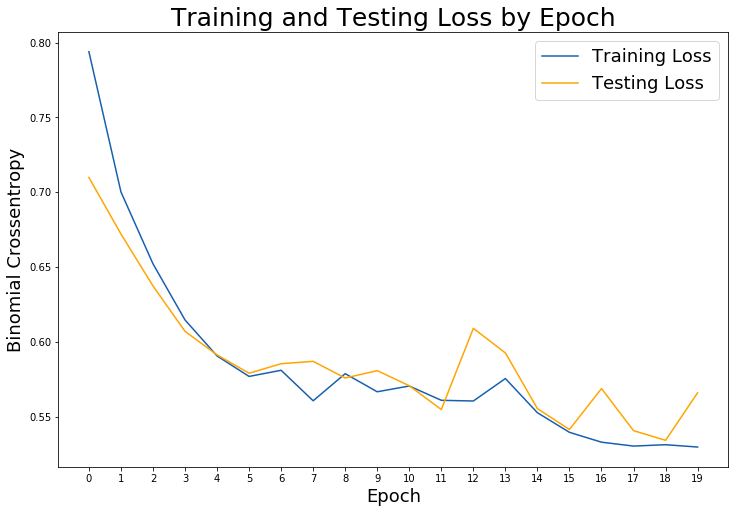

In [91]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binomial Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

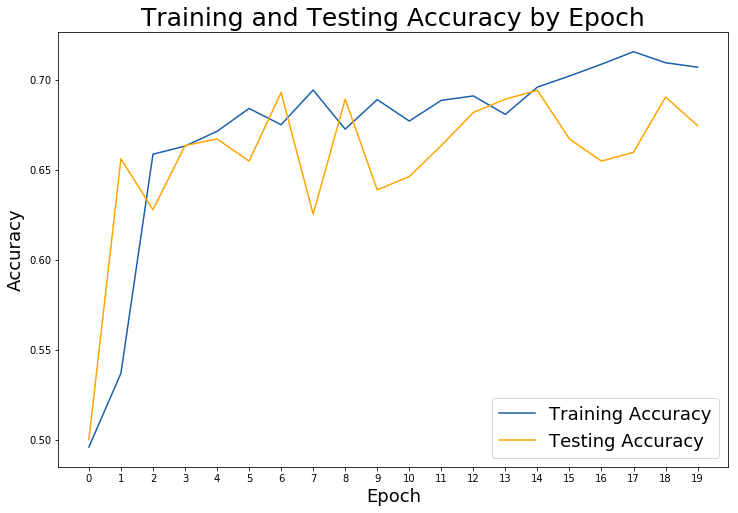

In [92]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [93]:
cnn_model.summary()

# Evaluate model on test data
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_labels = cnn_model.metrics_names

# Compare CNN and FFNN models.
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 6)         168       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
flatten_7 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               247936    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 249,113
Trainable params: 249,113
Non-trainable params: 0
_________________________________________________________________
CNN 

#### Building a second convolutional model

In [94]:
# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(28,28,3))) # shape of input (image)

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# Add another convolutional layer.
cnn_model_2.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a densely-connected layer with 16 neurons.
cnn_model_2.add(Dense(16, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_2.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)
# Fit model on training data
cnn_model_2.fit(X_train,
                y_train,
                batch_size=128,
                validation_data=(X_test, y_test),
                epochs=20,
                verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 2s 859us/step - loss: 0.6880 - acc: 0.5422 - val_loss: 0.6758 - val_acc: 0.5995
Epoch 2/20
2440/2440 [==============================] - 1s 479us/step - loss: 0.6742 - acc: 0.5648 - val_loss: 0.6498 - val_acc: 0.6450
Epoch 3/20
2440/2440 [==============================] - 1s 479us/step - loss: 0.6384 - acc: 0.6307 - val_loss: 0.6252 - val_acc: 0.6757
Epoch 4/20
2440/2440 [==============================] - 1s 484us/step - loss: 0.6134 - acc: 0.6607 - val_loss: 0.6019 - val_acc: 0.6523
Epoch 5/20
2440/2440 [==============================] - 1s 478us/step - loss: 0.6150 - acc: 0.6680 - val_loss: 0.6022 - val_acc: 0.6486
Epoch 6/20
2440/2440 [==============================] - 1s 502us/step - loss: 0.5932 - acc: 0.6779 - val_loss: 0.5904 - val_acc: 0.6855
Epoch 7/20
2440/2440 [==============================] - 1s 483us/step - loss: 0.6164 - acc: 0.6533 - val_loss: 0.5918 - val_acc: 0.6818
E

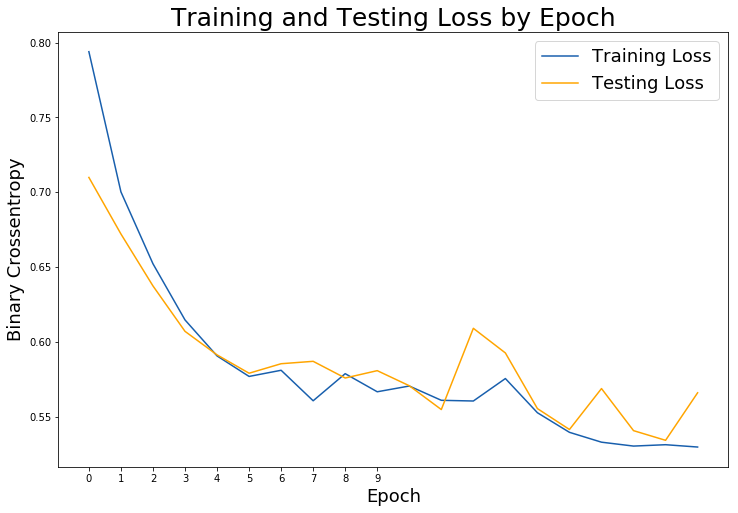

In [95]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9])

plt.legend(fontsize = 18);

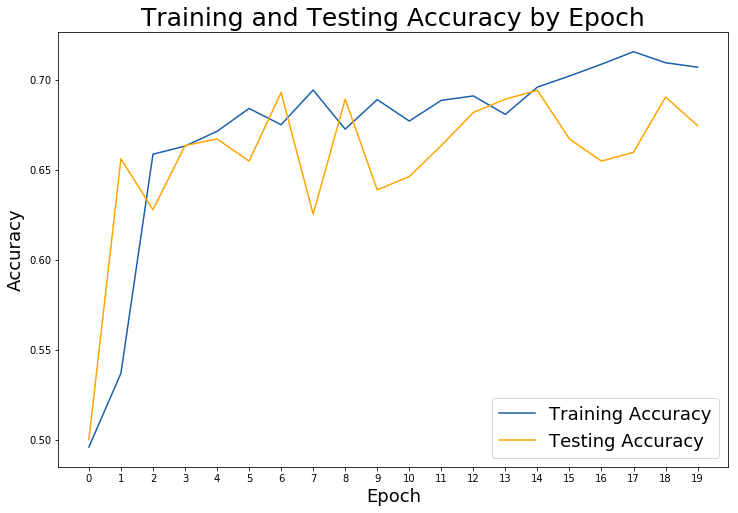

In [96]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [97]:
# Evaluate model on test data
cnn_2_score = cnn_model_2.evaluate(X_test, y_test, verbose=0)
cnn_2_labels = cnn_model_2.metrics_names

# Compare models.
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

cnn_model_2.summary()

CNN 2 loss  : 0.5439074385078299
CNN 2 acc   : 0.6990171988707503

CNN 1 loss  : 0.565918151957397
CNN 1 acc   : 0.6744471743007256

FFNN loss : 0.5902659238409937
FFNN acc  : 0.6449631454024912
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_22 (Den

#### Building a third convolutional model

In [98]:
# Instantiate a CNN.
cnn_model_3 = Sequential()

# Add a convolutional layer.
cnn_model_3.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(28,28,3))) # shape of input (image)

# Add a pooling layer.
cnn_model_3.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# Add another convolutional layer.
cnn_model_3.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_model_3.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_3.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_3.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_model_3.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_3.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_3.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 2s 875us/step - loss: 0.6922 - acc: 0.5418 - val_loss: 0.6770 - val_acc: 0.6843
Epoch 2/20
2440/2440 [==============================] - 1s 478us/step - loss: 0.6652 - acc: 0.5992 - val_loss: 0.6420 - val_acc: 0.6830
Epoch 3/20
2440/2440 [==============================] - 1s 539us/step - loss: 0.6432 - acc: 0.6303 - val_loss: 0.6381 - val_acc: 0.6597
Epoch 4/20
2440/2440 [==============================] - 1s 513us/step - loss: 0.6124 - acc: 0.6623 - val_loss: 0.6064 - val_acc: 0.6880
Epoch 5/20
2440/2440 [==============================] - 1s 493us/step - loss: 0.5924 - acc: 0.6865 - val_loss: 0.6092 - val_acc: 0.6646
Epoch 6/20
2440/2440 [==============================] - 1s 494us/step - loss: 0.6051 - acc: 0.6684 - val_loss: 0.5771 - val_acc: 0.6843
Epoch 7/20
2440/2440 [==============================] - 1s 482us/step - loss: 0.6026 - acc: 0.6693 - val_loss: 0.5816 - val_acc: 0.6880
E

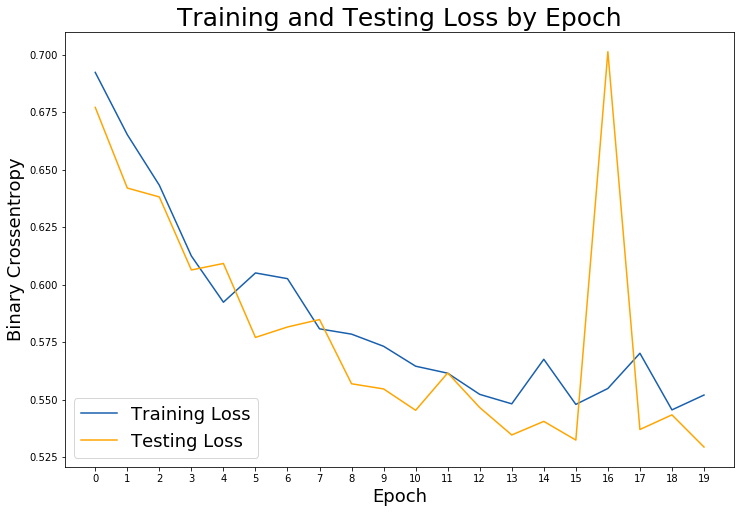

In [99]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

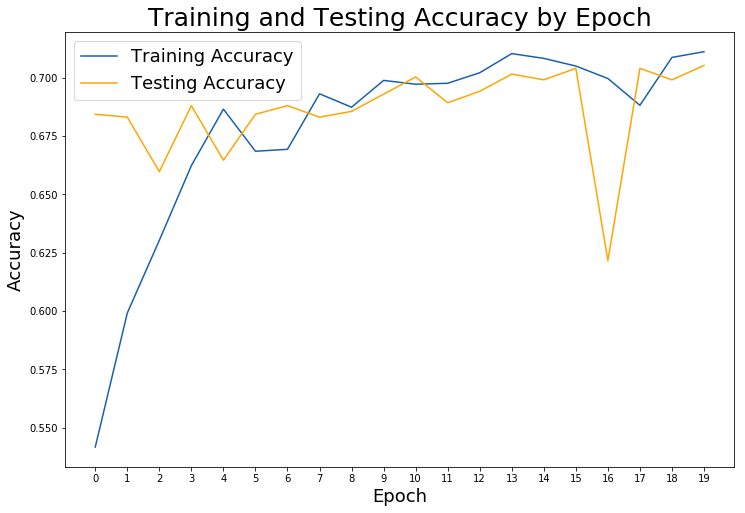

In [100]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [101]:
# Evaluate model on test data.
cnn_3_score = cnn_model_3.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_3_labels = cnn_model_3.metrics_names

# Compare models.
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 243us/step
CNN 3 loss  : 0.5294231372617679
CNN 3 acc   : 0.7051597050132564

CNN 2 loss  : 0.5439074385078299
CNN 2 acc   : 0.6990171988707503

CNN 1 loss  : 0.565918151957397
CNN 1 acc   : 0.6744471743007256

FFNN loss : 0.5902659238409937
FFNN acc  : 0.6449631454024912


### Fourth convolutional model - with data augmentation

In [102]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [103]:
# Instantiate a CNN.
cnn_4_model = Sequential()

# Add a convolutional layer.
cnn_4_model.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(28,28,3))) # shape of input (image)

# Add another convolutional layer.
cnn_4_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_4_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# Add another convolutional layer.
cnn_4_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_4_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# Add another convolutional layer.
cnn_4_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_4_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_4_model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_4_model.add(Dense(512, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))

# Add a densely-connected layer with 64 neurons.
cnn_4_model.add(Dense(256, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))



# Add a densely-connected layer with 64 neurons.
cnn_4_model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_4_model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_4_model.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_4_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)


# Fit the model
epochs = 20 
batch_size = 8
history = cnn_4_model.fit_generator(datagen.flow(X_train,y_train,
                                           batch_size=batch_size),
                                           epochs = epochs,
                                           validation_data = (X_test,y_test),
                                           verbose = 1,
                                           steps_per_epoch=X_train.shape[0] // batch_size)
                              


Epoch 1/20
305/305 [==============================] - 7s 23ms/step - loss: 0.6941 - acc: 0.5008 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/20
305/305 [==============================] - 6s 19ms/step - loss: 0.6948 - acc: 0.4963 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/20
305/305 [==============================] - 6s 19ms/step - loss: 0.6935 - acc: 0.5086 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 4/20
305/305 [==============================] - 6s 19ms/step - loss: 0.6952 - acc: 0.4922 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/20
305/305 [==============================] - 6s 19ms/step - loss: 0.6934 - acc: 0.5135 - val_loss: 0.6824 - val_acc: 0.5000
Epoch 6/20
305/305 [==============================] - 6s 19ms/step - loss: 0.6843 - acc: 0.5406 - val_loss: 0.6937 - val_acc: 0.5012
Epoch 7/20
305/305 [==============================] - 6s 19ms/step - loss: 0.6935 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5012
Epoch 8/20
305/305 [==============================] - 6s 19ms/step - 

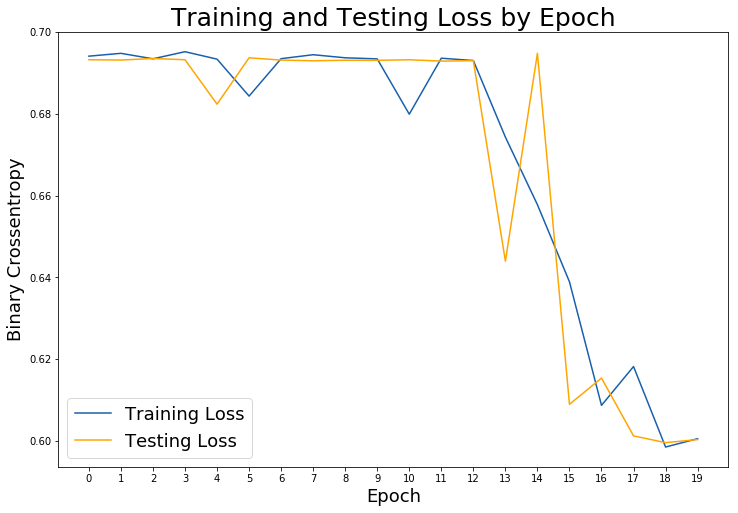

In [104]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

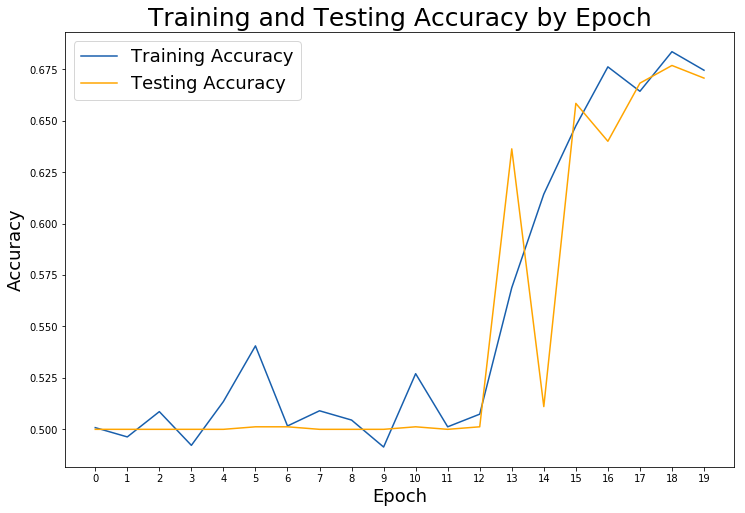

In [105]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [106]:
# Evaluate model on test data.
cnn_4_score = cnn_4_model.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_4_labels = cnn_4_model.metrics_names

# Compare models.
print(f'CNN 4 {cnn_4_labels[0]}  : {cnn_4_score[0]}')
print(f'CNN 4 {cnn_4_labels[1]}   : {cnn_4_score[1]}')
print()
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 381us/step
CNN 4 loss  : 0.6003239882666004
CNN 4 acc   : 0.670761670615222

CNN 3 loss  : 0.5294231372617679
CNN 3 acc   : 0.7051597050132564

CNN 2 loss  : 0.5439074385078299
CNN 2 acc   : 0.6990171988707503

CNN 1 loss  : 0.565918151957397
CNN 1 acc   : 0.6744471743007256

FFNN loss : 0.5902659238409937
FFNN acc  : 0.6449631454024912
